<a href="https://colab.research.google.com/github/OlyaMizonova/MachineLearning/blob/main/%D0%9C%D0%B8%D0%B7%D0%BE%D0%BD%D0%BE%D0%B2%D0%B0_%D0%9E%D0%BB%D1%8C%D0%B3%D0%B0_%D0%9F%D0%9C%D0%982_%D0%94%D0%97_5_%D0%BF%D0%BE_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%BC%D1%83_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Необходимо решить задачу кластеризации для тех данных, для которых ранее решалась задача классификации. Будут использованы следующие методы:



Импортируем библиотеки, которые понадобятся нам далее

In [1]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

Загружаем датасет

In [2]:
path = kagglehub.dataset_download("dansbecker/melbourne-housing-snapshot")
csv_file = "melb_data.csv"
df = pd.read_csv(os.path.join(path, csv_file))

Using Colab cache for faster access to the 'melbourne-housing-snapshot' dataset.


Далее будет повторена вся предобработка, как и в прошлом домашнем задании, за исключением того факта, что теперь разделение на тренировочную и тестовую выборки теперь не требуется.

In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y') #переводим дату в соответствующий формат

In [4]:
parts = df['Address'].str.split() # разделяем адрес на составные части
df['house_number'] = parts.str[0]
df['street_type'] = parts.str[-1]
df['street_name'] = parts.str[1:-1].str.join(' ')
df = df.drop(columns=['Address'])

In [5]:
df = df.drop(columns=['street_name','house_number']) #удаляем ненужные признаки

In [6]:
mapping = {
    #Проспект
    'Av': 'Avenue',
    'Ave': 'Avenue',

    #Роща
    'Gr': 'Grove',
    'Gra': 'Grove',

    #Стороны света
    'N': 'North',
    'S': 'South',
    'W': 'West',
    'E': 'East',

    #Шоссе
    'Hwy': 'Highway',

    #Бульвар
    'Bvd': 'Boulevard',

    #Набережная
    'Esp': 'Esplanade',

    #Парк
    'Pde': 'Parade',
}


df['street_type'] = df['street_type'].replace(mapping) #объединяем уникальные значения признаков по смыслу

In [7]:
sold_methods = {'S', 'SP', 'SA'}

df['is_sold'] = df['Method'].isin(sold_methods).astype(int) #создаем метку, которую будем предсказывать

In [8]:
df=df.drop('Method', axis=1)

In [9]:
X = df.drop(['is_sold'], axis=1)
y = df['is_sold']

Далее объединяем редкие значения признаков в один

In [10]:
threshold = 60
value_counts = X['Suburb'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X['Suburb'] = X['Suburb'].apply(lambda x: 'Other' if x not in allowed_values else x)


In [11]:
threshold = 30
value_counts = X['SellerG'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X['SellerG'] = X['SellerG'].apply(lambda x: 'Other' if x not in allowed_values else x)


In [12]:
threshold = 50
value_counts = X['CouncilArea'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X['CouncilArea'] = X['CouncilArea'].apply(lambda x: 'Other' if x not in allowed_values else x)

In [13]:
threshold = 40
value_counts = X['Regionname'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X['Regionname'] = X['Regionname'].apply(lambda x: 'Other' if x not in allowed_values else x)

In [14]:
threshold1 = 100
value_counts1 = X['street_type'].value_counts()
frequent_values1 = value_counts1[value_counts1 >= threshold].index
allowed_values1 = set(frequent_values1)

X['street_type'] = X['street_type'].apply(lambda x: 'Other' if x not in allowed_values1 else x)

Переводим признаки в категориальные

In [15]:
X['Suburb'] = X['Suburb'].astype('category')

X['street_type'] = X['street_type'].astype('category')

X['SellerG'] = X['SellerG'].astype('category')

X['CouncilArea'] = X['CouncilArea'].astype('category')

X['Regionname'] = X['Regionname'].astype('category')

X['Type'] = X['Type'].astype('category')

Обработка числовых признаков:

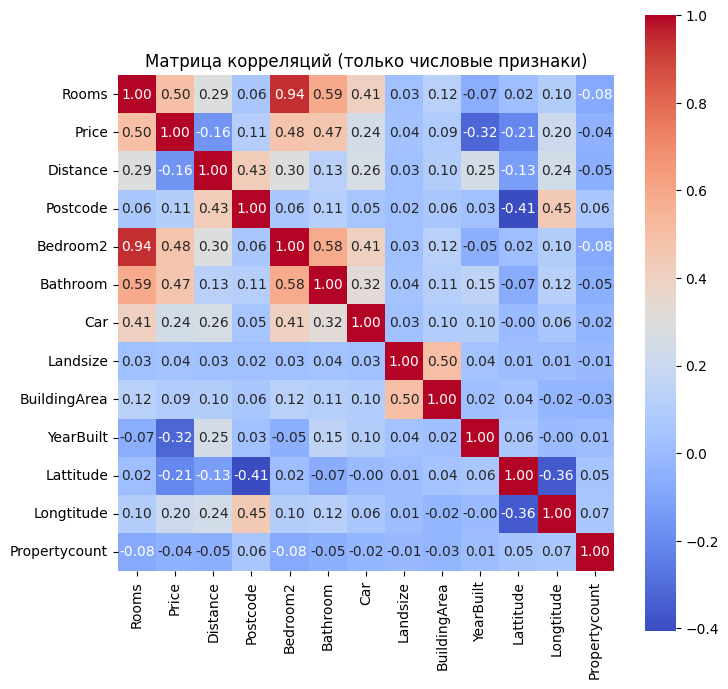

In [16]:
df = X.copy()
numeric_df = df.select_dtypes(include=['number'])
numeric_df = numeric_df.astype('float64')


corr_mat = numeric_df.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Матрица корреляций (только числовые признаки)')
plt.show()

In [17]:
corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending=False)

Rooms     Bedroom2        0.944190
          Bathroom        0.592934
Bedroom2  Bathroom        0.584685
Landsize  BuildingArea    0.500485
dtype: float64

In [18]:
X = X.assign(TotalRooms = X['Rooms'] + X['Bathroom']) #два коррелирующих признака объединили в один

In [19]:
X = X.drop('Bedroom2', axis=1)
X = X.drop('Rooms', axis=1)
X = X.drop('Bathroom', axis=1)

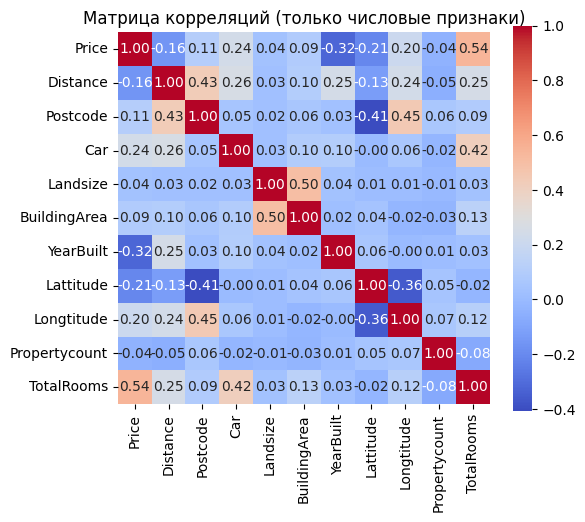

In [20]:
train_df = X.copy()
numeric_df = train_df.select_dtypes(include=['number'])
numeric_df = numeric_df.astype('float64')


corr_mat = numeric_df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Матрица корреляций (только числовые признаки)')
plt.show()

In [21]:
X = X.assign(TotalArea = X['Landsize'] + X['BuildingArea']) #два коррелирующих признака объединили в один
X = X.drop('BuildingArea', axis=1)
X = X.drop('Landsize', axis=1)

обрабатываем выбросы

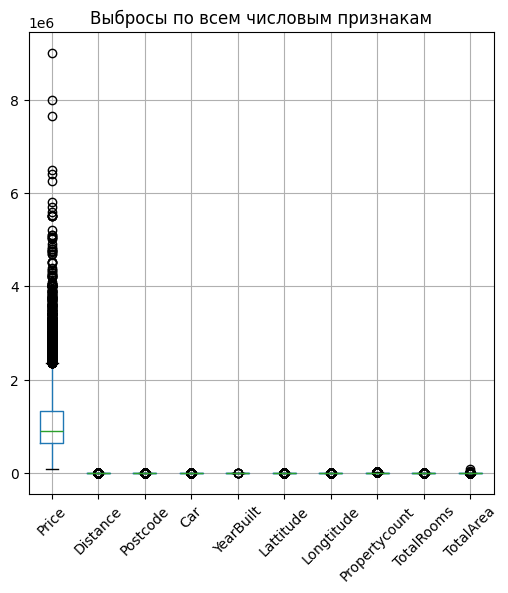

In [22]:
numeric_cols = X.select_dtypes(include=['number']).columns

plt.figure(figsize=(6, 6))
X[numeric_cols].boxplot()
plt.title('Выбросы по всем числовым признакам')
plt.xticks(rotation=45)
plt.show()

In [23]:
rows = X[(X['Price'] < X['Price'].quantile(0.005)) | (X['Price'] > X['Price'].quantile(0.995))]
print(rows.shape)

(129, 17)


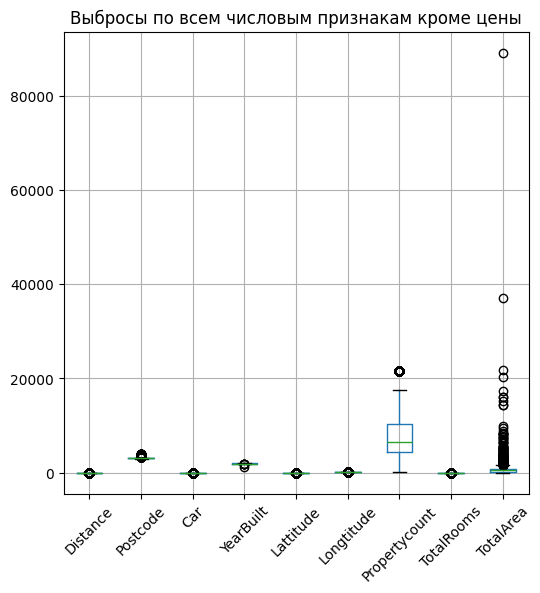

In [24]:
numeric_cols = X.select_dtypes(include=['number']).columns
numeric_cols_no_price = numeric_cols.drop('Price')
plt.figure(figsize=(6, 6))
X[numeric_cols_no_price].boxplot()
plt.title('Выбросы по всем числовым признакам кроме цены')
plt.xticks(rotation=45)
plt.show()

In [25]:
rows_to_drop = X[
    (X['Price'] < X['Price'].quantile(0.005)) | (X['Price'] > X['Price'].quantile(0.995))|
    (X['TotalArea']  < X['TotalArea' ].quantile(0.005)) | (X['TotalArea']  > X['TotalArea' ].quantile(0.995))|
    (X['Propertycount']  < X['Propertycount' ].quantile(0.005)) | (X['Propertycount']  > X['Propertycount' ].quantile(0.995))].index

In [26]:
X = X.drop(rows_to_drop)
y = y.drop(rows_to_drop)

обрабатываем пропущенные значения

In [27]:
numeric_cols = X.select_dtypes(include=['number']).columns

numeric_medians = X[numeric_cols].median()
X[numeric_cols] = X[numeric_cols].fillna(numeric_medians)

кодируем категориальные признаки

In [28]:
categorical_columns = X.select_dtypes(include=['category']).columns.tolist()

ohe = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False)

ohe.fit(X[categorical_columns])

X_cat_ohe = ohe.transform(X[categorical_columns])

ohe_feature_names = ohe.get_feature_names_out(categorical_columns)

X_cat_df = pd.DataFrame(X_cat_ohe, columns=ohe_feature_names, index=X.index)

numerical_columns = [col for col in X.columns if col not in categorical_columns]

X = pd.concat([X[numerical_columns], X_cat_df], axis=1)

переводим дату в количество дней от минимальной даты

In [29]:
min_date = X['Date'].min()

X['DaysSinceStart'] = (X['Date'] - min_date).dt.days

X = X.drop('Date', axis=1)

нормализуем числовые признаки

In [30]:
numerical_columns = ['Postcode','TotalRooms', 'Distance', 'Car',
                     'TotalArea', 'YearBuilt', 'Lattitude', 'Longtitude',
                     'DaysSinceStart', 'Propertycount','Price']

scaler = StandardScaler()

X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

Теперь начнем решать задачу кластеризации

Понизим размерность с помощью PCA

In [31]:
from sklearn.decomposition import PCA

Сначала посмотрим, что будет, если понизить размерность до двух компонент

In [32]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(f"Объясненная дисперсия 2 компонент: {sum(pca.explained_variance_ratio_):.2%}")

Объясненная дисперсия 2 компонент: 28.59%


**1. KMeans**

In [ ]:
from sklearn.cluster import KMeans

Для подбора k - количества класса попробуем использовать метод локтя

In [68]:
max_k=30
k_range = range(1, max_k + 1)
inertia = []
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

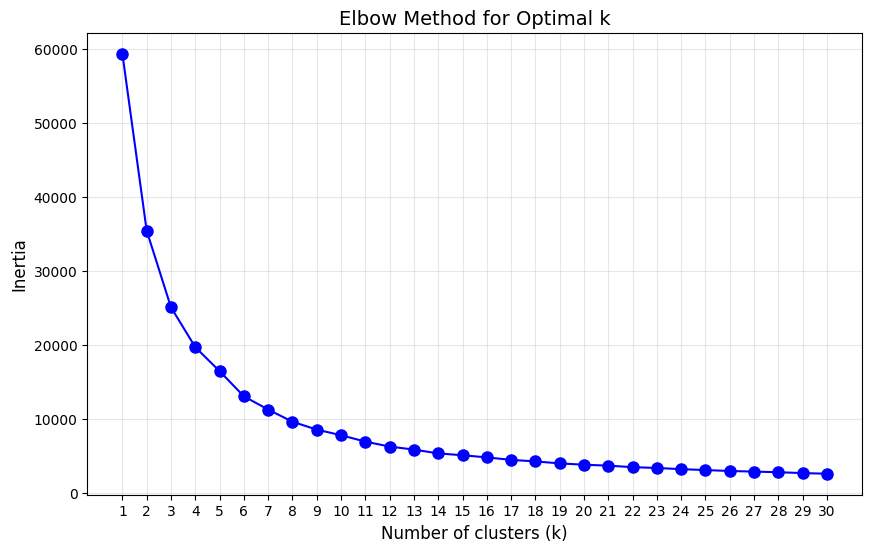

In [69]:
# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.show()

Метод локтя не дал очевидного ответа, попробуем другие методы

In [71]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

scores = {'silhouette': [], 'calinski': [], 'davies': []}
k_range = range(2, max_k)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)

    if len(set(labels)) > 1:  # нужно больше 1 кластера
        scores['silhouette'].append(silhouette_score(X_pca, labels))
        scores['calinski'].append(calinski_harabasz_score(X_pca, labels))
        scores['davies'].append(davies_bouldin_score(X_pca, labels))

# Оптимальные k по разным метрикам
optimal_k = {
    'silhouette': k_range[np.argmax(scores['silhouette'])],
    'calinski': k_range[np.argmax(scores['calinski'])],
    'davies': k_range[np.argmin(scores['davies'])]
}

In [72]:
print(optimal_k)

{'silhouette': 2, 'calinski': 15, 'davies': 11}


Попробуем использовать 2 класса, 15, а потом 11





In [78]:
kmeans2 = KMeans(n_clusters=2, random_state=42)
kmeans_labels2 = kmeans2.fit_predict(X_pca)

In [79]:
kmeans15 = KMeans(n_clusters=15, random_state=42)
kmeans_labels15 = kmeans15.fit_predict(X_pca)

In [80]:
kmeans11 = KMeans(n_clusters=11, random_state=42)
kmeans_labels11 = kmeans11.fit_predict(X_pca)

In [57]:
import matplotlib.pyplot as plt
import numpy as np

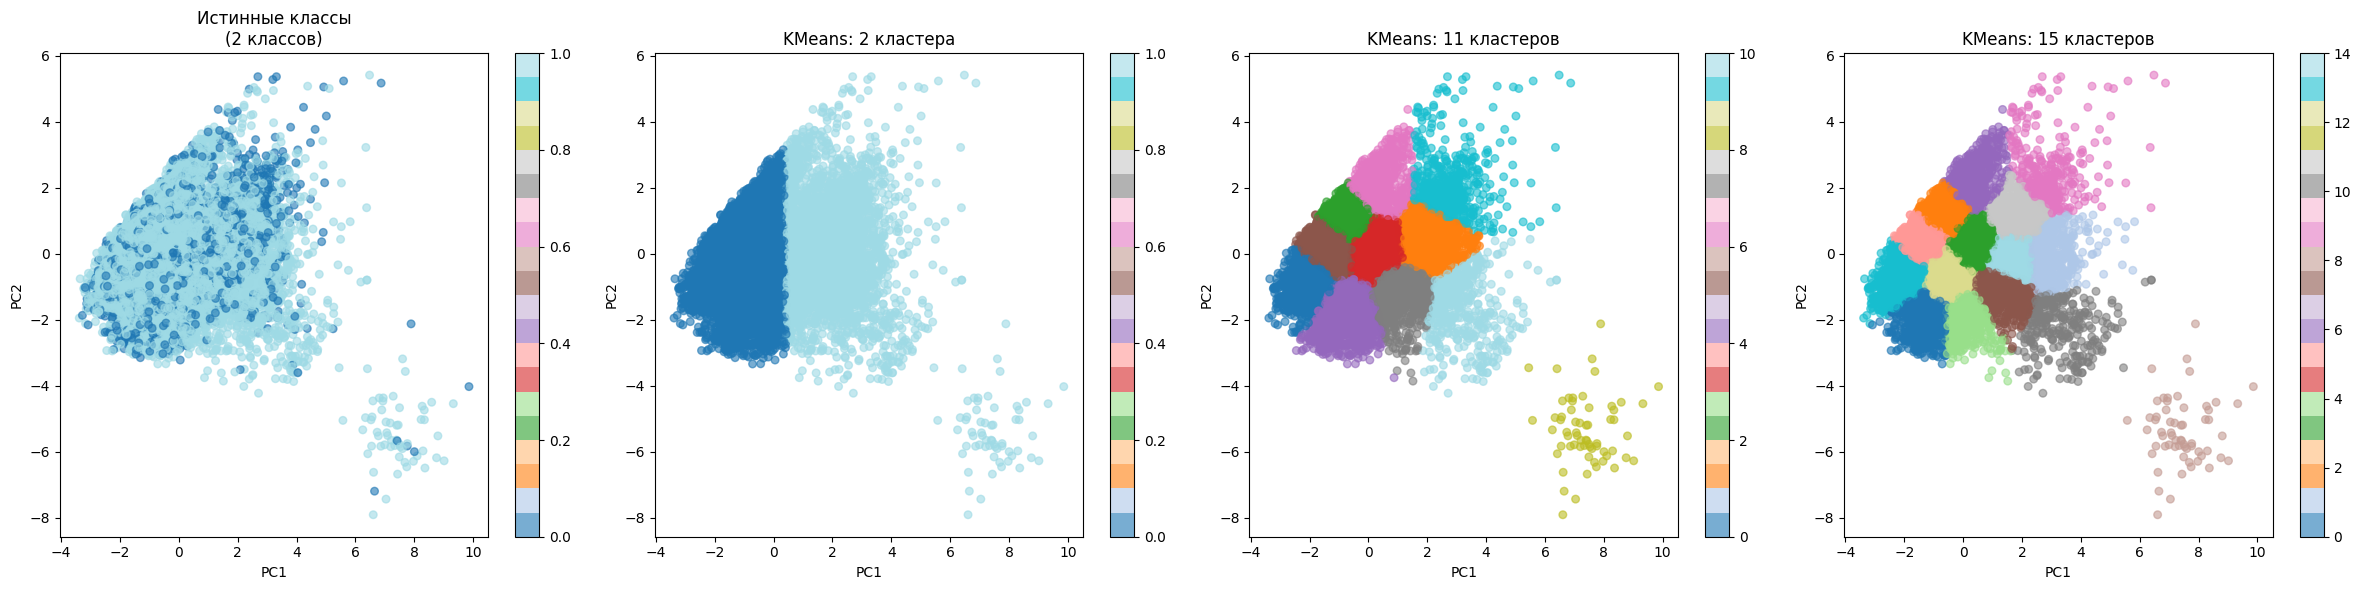

=== Анализ кластеризации ===
KMeans (k=2):
  - Число кластеров: 2
  - Размеры кластеров: [8604 4719]
  - Доля объектов: [0.6458005 0.3541995]

KMeans (k=11):
  - Число кластеров: 11
  - Размеры кластеров: [1289 1401 2034 1538 1604 2189  883 1245   62  549  529]
  - Минимальный размер: 62
  - Максимальный размер: 2189

KMeans (k=15):
  - Число кластеров: 15
  - Размеры кластеров: [ 879  499 1789 1148  682 2033  702  922   61  338  288  797  991 1371
  823]
  - Минимальный размер: 61
  - Максимальный размер: 2033


In [81]:
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

scatter0 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y,
                              cmap='tab20', alpha=0.6, s=30)
axes[0].set_title(f'Истинные классы\n({len(np.unique(y))} классов)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
plt.colorbar(scatter0, ax=axes[0])

# График 2: KMeans с 2 кластерами
scatter1 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels2,
                          cmap='tab20', alpha=0.6, s=30)
axes[1].set_title('KMeans: 2 кластера')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
plt.colorbar(scatter1, ax=axes[1])

# График 3: KMeans с 11 кластерами
scatter2 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels11,
                          cmap='tab20', alpha=0.6, s=30)
axes[2].set_title('KMeans: 11 кластеров')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
plt.colorbar(scatter2, ax=axes[2])

# График 4: KMeans с 15 кластерами
scatter3 = axes[3].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels15,
                          cmap='tab20', alpha=0.6, s=30)
axes[3].set_title('KMeans: 15 кластеров')
axes[3].set_xlabel('PC1')
axes[3].set_ylabel('PC2')
plt.colorbar(scatter3, ax=axes[3])

plt.tight_layout()
plt.show()

# Анализ результатов
print("=== Анализ кластеризации ===")
print(f"KMeans (k=2):")
print(f"  - Число кластеров: {len(np.unique(kmeans_labels2))}")
print(f"  - Размеры кластеров: {np.bincount(kmeans_labels2)}")
print(f"  - Доля объектов: {np.bincount(kmeans_labels2) / len(kmeans_labels2)}")

print(f"\nKMeans (k=11):")
print(f"  - Число кластеров: {len(np.unique(kmeans_labels11))}")
print(f"  - Размеры кластеров: {np.bincount(kmeans_labels11)}")
print(f"  - Минимальный размер: {np.min(np.bincount(kmeans_labels11))}")
print(f"  - Максимальный размер: {np.max(np.bincount(kmeans_labels11))}")

print(f"\nKMeans (k=15):")
print(f"  - Число кластеров: {len(np.unique(kmeans_labels15))}")
print(f"  - Размеры кластеров: {np.bincount(kmeans_labels15)}")
print(f"  - Минимальный размер: {np.min(np.bincount(kmeans_labels15))}")
print(f"  - Максимальный размер: {np.max(np.bincount(kmeans_labels15))}")




=== Сравнение с истинными метками ===

Таблица метрик:
       Method  Adjusted Rand Score  Normalized Mutual Info
 KMeans (k=2)             0.013359                0.001682
KMeans (k=11)             0.005470                0.006931
KMeans (k=15)             0.005691                0.006856


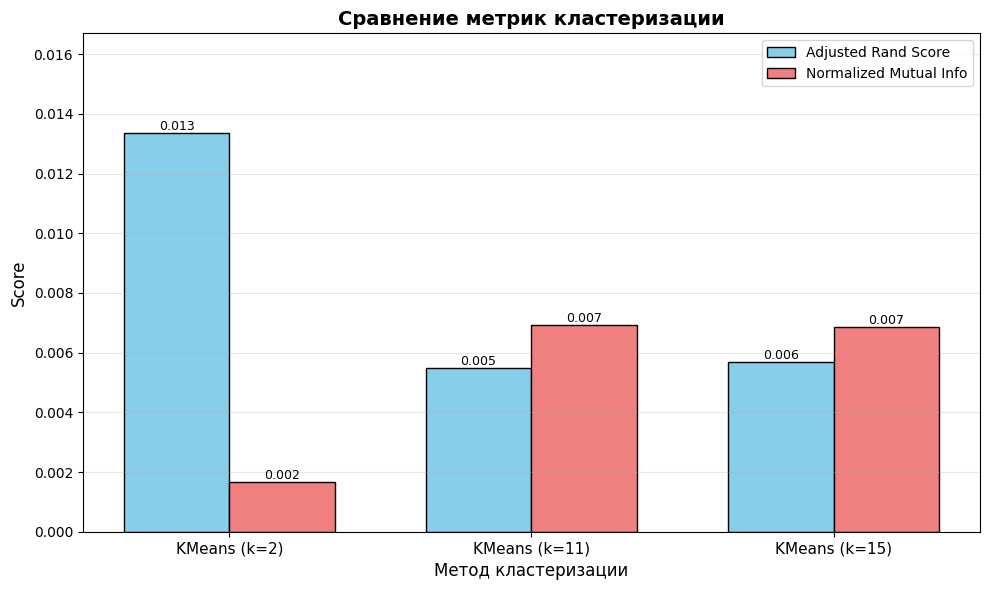

In [84]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

if 'y' in locals() and y is not None:
    print("\n=== Сравнение с истинными метками ===")

    methods = {
        'KMeans (k=2)': kmeans_labels2,
        'KMeans (k=11)': kmeans_labels11,
        'KMeans (k=15)': kmeans_labels15
    }

    results = []
    for name, labels in methods.items():
        results.append({
            'Method': name,
            'Adjusted Rand Score': adjusted_rand_score(y, labels),
            'Normalized Mutual Info': normalized_mutual_info_score(y, labels)
        })

    results_df = pd.DataFrame(results)
    print("\nТаблица метрик:")
    print(results_df.to_string(index=False))

    # Визуализация метрик - ТОЛЬКО ОДИН ГРАФИК
    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(results_df))
    width = 0.35

    bars1 = ax.bar(x - width/2, results_df['Adjusted Rand Score'], width,
                   label='Adjusted Rand Score', color='skyblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, results_df['Normalized Mutual Info'], width,
                   label='Normalized Mutual Info', color='lightcoral', edgecolor='black')

    # Добавляем значения на столбцы
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    ax.set_xlabel('Метод кластеризации', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Сравнение метрик кластеризации', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Method'], rotation=0, fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

    # Автоматически устанавливаем верхний предел оси Y
    max_value = max(results_df['Adjusted Rand Score'].max(),
                    results_df['Normalized Mutual Info'].max())
    ax.set_ylim(0, max_value * 1.25)

    plt.tight_layout()
    plt.show()

else:
    print("Истинные метки (y) не найдены. Сравнение невозможно.")

# Все три варианта дали довольно плохие результаты, возможно, этот метод плохо справляется с этим датасетом.

2. **DBSCAN**

Text(0.5, 1.0, 'Метод локтя для подбора eps в DBSCAN')

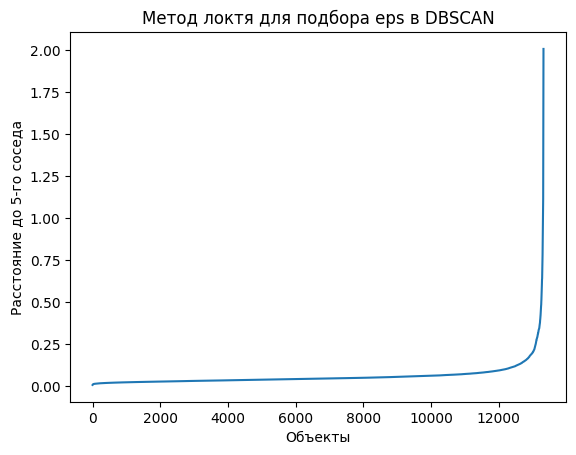

In [85]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Автоподбор eps (метод k-distance)
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_pca)
distances, indices = nn.kneighbors(X_pca)
distances = np.sort(distances[:, 4], axis=0)

# Визуализация для выбора eps
plt.plot(distances)
plt.xlabel('Объекты')
plt.ylabel('Расстояние до 5-го соседа')
plt.title('Метод локтя для подбора eps в DBSCAN')


In [86]:
# Кластеризация DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

=== Анализ DBSCAN кластеризации ===
Найдено кластеров: 7
Шумовые точки: 224 (1.7%)
Уникальные метки: [-1  0  1  2  3  4  5  6]
Размеры кластеров:
  Кластер 0: 13032 точек
  Кластер 1: 10 точек
  Кластер 2: 5 точек
  Кластер 3: 27 точек
  Кластер 4: 11 точек
  Кластер 5: 9 точек
  Кластер 6: 5 точек


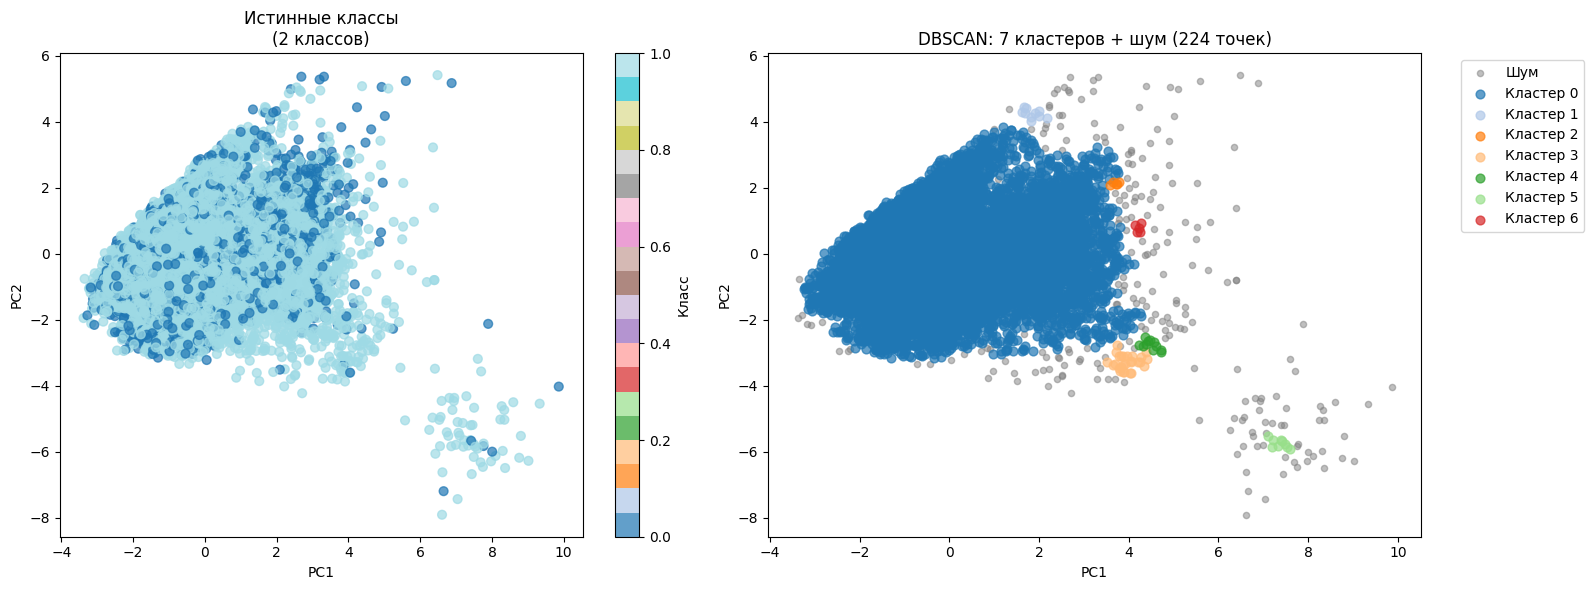


=== Сравнение DBSCAN с истинными метками ===
Adjusted Rand Score: -0.002
Normalized Mutual Info: 0.001

Распределение истинных классов по кластерам DBSCAN:

Шум (-1):
  Класс 0: 44 точек (19.6%)
  Класс 1: 180 точек (80.4%)

Кластер 0:
  Класс 0: 2617 точек (20.1%)
  Класс 1: 10415 точек (79.9%)

Кластер 1:
  Класс 0: 4 точек (40.0%)
  Класс 1: 6 точек (60.0%)

Кластер 2:
  Класс 0: 2 точек (40.0%)
  Класс 1: 3 точек (60.0%)

Кластер 3:
  Класс 0: 2 точек (7.4%)
  Класс 1: 25 точек (92.6%)

Кластер 4:
  Класс 1: 11 точек (100.0%)

Кластер 5:
  Класс 0: 1 точек (11.1%)
  Класс 1: 8 точек (88.9%)

Кластер 6:
  Класс 0: 1 точек (20.0%)
  Класс 1: 4 точек (80.0%)


In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Кластеризация DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

# Анализ результатов DBSCAN
print("=== Анализ DBSCAN кластеризации ===")
unique_labels = np.unique(dbscan_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Найдено кластеров: {n_clusters}")
print(f"Шумовые точки: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")
print(f"Уникальные метки: {unique_labels}")
print(f"Размеры кластеров:")
for label in unique_labels:
    if label != -1:
        print(f"  Кластер {label}: {np.sum(dbscan_labels == label)} точек")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Истинные метки (если есть)
if 'y' in locals() and y is not None:
    scatter0 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y,
                              cmap='tab20', alpha=0.7, s=40)
    axes[0].set_title(f'Истинные классы\n({len(np.unique(y))} классов)')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    plt.colorbar(scatter0, ax=axes[0], label='Класс')
else:
    # Если истинных меток нет, показываем исходные данные
    axes[0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=40)
    axes[0].set_title('Исходные данные')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')

# График 2: Кластеризация DBSCAN
# Создаем специальную цветовую карту для DBSCAN (шум серым цветом)
cmap = plt.cm.tab20
colors = [cmap(i) for i in range(len(unique_labels))]

# Шумовые точки (-1) показываем серым цветом
if -1 in unique_labels:
    noise_mask = dbscan_labels == -1
    axes[1].scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1],
                   c='gray', alpha=0.5, s=20, label='Шум')

# Кластеры
for label in unique_labels:
    if label != -1:
        mask = dbscan_labels == label
        axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1],
                       c=[cmap(label % 20)], alpha=0.7, s=40,
                       label=f'Кластер {label}')

axes[1].set_title(f'DBSCAN: {n_clusters} кластеров + шум ({n_noise} точек)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Дополнительная информация
if 'y' in locals() and y is not None:
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    print("\n=== Сравнение DBSCAN с истинными метками ===")
    print(f"Adjusted Rand Score: {adjusted_rand_score(y, dbscan_labels):.3f}")
    print(f"Normalized Mutual Info: {normalized_mutual_info_score(y, dbscan_labels):.3f}")

    # Показываем распределение истинных классов по кластерам DBSCAN
    if len(unique_labels) <= 10:  # Если не слишком много кластеров
        print("\nРаспределение истинных классов по кластерам DBSCAN:")
        for label in unique_labels:
            if label == -1:
                print(f"\nШум (-1):")
            else:
                print(f"\nКластер {label}:")

            mask = dbscan_labels == label
            if np.any(mask):
                unique_y_in_cluster, counts = np.unique(y[mask], return_counts=True)
                for y_label, count in zip(unique_y_in_cluster, counts):
                    percentage = count / np.sum(mask) * 100
                    print(f"  Класс {y_label}: {count} точек ({percentage:.1f}%)")

Результат получился еще хуже, чем при первом методе

In [89]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=2, linkage='ward')
agglo_labels = agglo.fit_predict(X_pca)

In [90]:
from sklearn.cluster import AgglomerativeClustering

agglo11 = AgglomerativeClustering(n_clusters=11, linkage='ward')
agglo_label11s = agglo11.fit_predict(X_pca)

=== Анализ Agglomerative Clustering ===
Кластеризация с 2 кластерами:
  - Уникальные метки: [0 1]
  - Размеры кластеров: [9229 4094]
  - Доли: [0.69271185 0.30728815]

Кластеризация с 11 кластерами:
  - Уникальные метки: [ 0  1  2  3  4  5  6  7  8  9 10]
  - Размеры кластеров: [1508  723 1005 2640 1732 1555 1464   62 1177  749  708]
  - Минимальный размер: 62
  - Максимальный размер: 2640


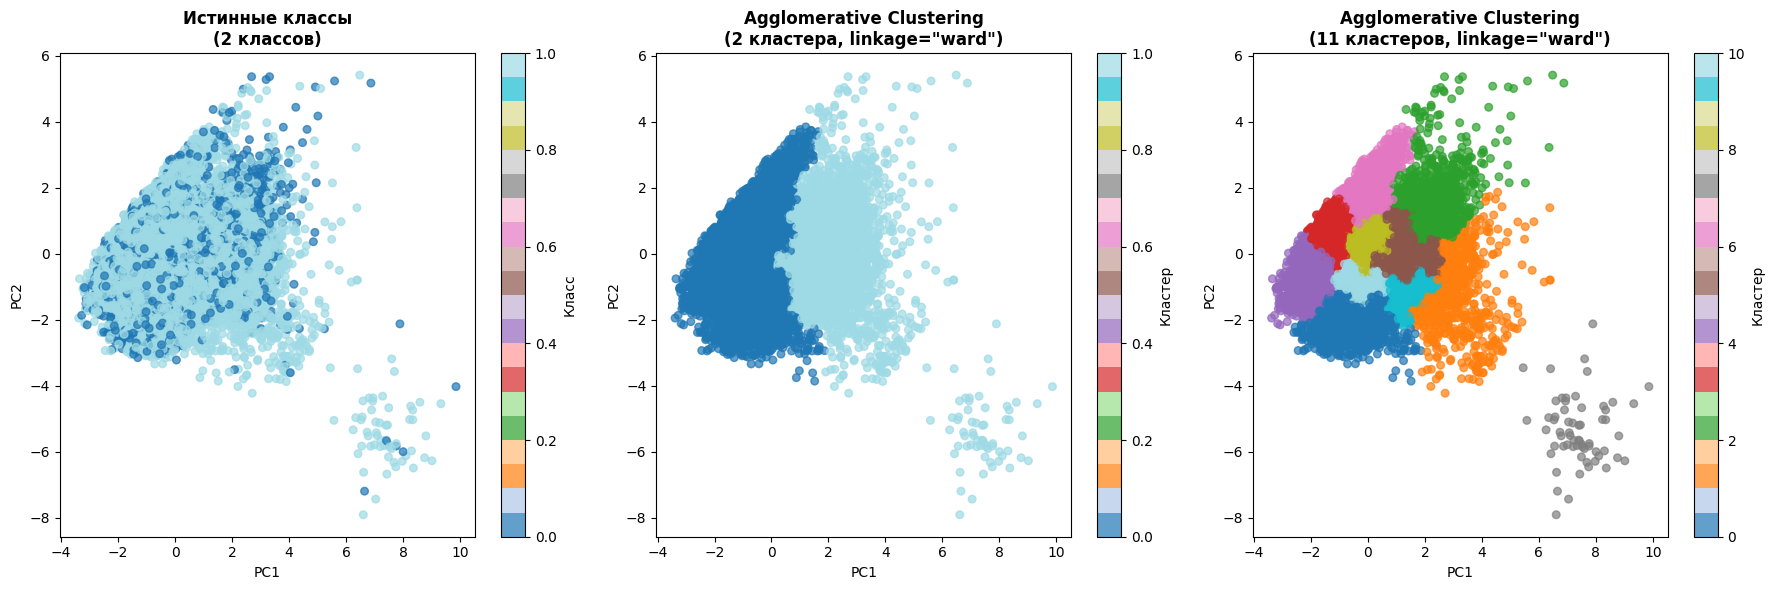


=== Сравнение с истинными метками ===


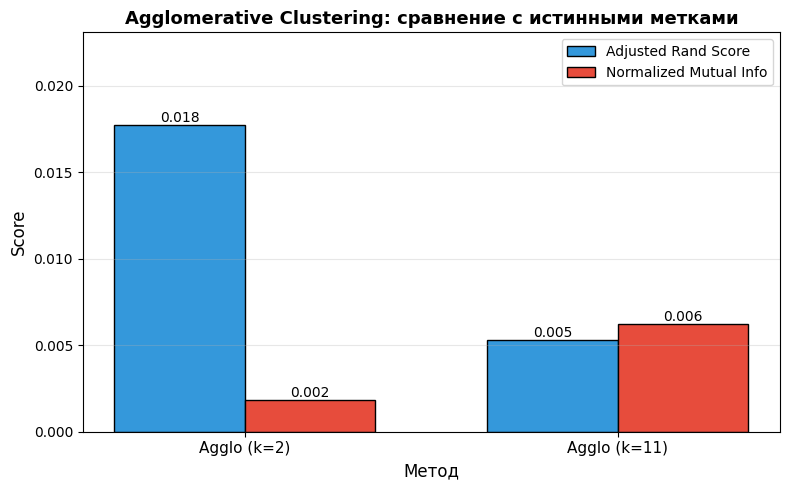


Таблица метрик:
      Method  Adjusted Rand Score  Normalized Mutual Info
 Agglo (k=2)             0.017761                0.001861
Agglo (k=11)             0.005288                0.006214


In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

# Кластеризация Agglomerative Clustering с разным числом кластеров
agglo2 = AgglomerativeClustering(n_clusters=2, linkage='ward')
agglo_labels2 = agglo2.fit_predict(X_pca)

agglo11 = AgglomerativeClustering(n_clusters=11, linkage='ward')
agglo_labels11 = agglo11.fit_predict(X_pca)

# Анализ результатов
print("=== Анализ Agglomerative Clustering ===")
print(f"Кластеризация с 2 кластерами:")
print(f"  - Уникальные метки: {np.unique(agglo_labels2)}")
print(f"  - Размеры кластеров: {np.bincount(agglo_labels2)}")
print(f"  - Доли: {np.bincount(agglo_labels2) / len(agglo_labels2)}")

print(f"\nКластеризация с 11 кластерами:")
print(f"  - Уникальные метки: {np.unique(agglo_labels11)}")
print(f"  - Размеры кластеров: {np.bincount(agglo_labels11)}")
print(f"  - Минимальный размер: {np.min(np.bincount(agglo_labels11))}")
print(f"  - Максимальный размер: {np.max(np.bincount(agglo_labels11))}")

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# График 1: Истинные метки (если есть)
if 'y' in locals() and y is not None:
    scatter0 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y,
                              cmap='tab20', alpha=0.7, s=30)
    axes[0].set_title(f'Истинные классы\n({len(np.unique(y))} классов)',
                     fontsize=12, fontweight='bold')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    plt.colorbar(scatter0, ax=axes[0], label='Класс')
else:
    axes[0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=30)
    axes[0].set_title('Исходные данные', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')

# График 2: Agglomerative Clustering с 2 кластерами
scatter1 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels2,
                          cmap='tab20', alpha=0.7, s=30)
axes[1].set_title('Agglomerative Clustering\n(2 кластера, linkage="ward")',
                 fontsize=12, fontweight='bold')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
plt.colorbar(scatter1, ax=axes[1], label='Кластер')

# График 3: Agglomerative Clustering с 11 кластерами
scatter2 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels11,
                          cmap='tab20', alpha=0.7, s=30)
axes[2].set_title('Agglomerative Clustering\n(11 кластеров, linkage="ward")',
                 fontsize=12, fontweight='bold')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
plt.colorbar(scatter2, ax=axes[2], label='Кластер')

plt.tight_layout()
plt.show()

# Сравнение с истинными метками (если есть)
if 'y' in locals() and y is not None:
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    print("\n=== Сравнение с истинными метками ===")

    methods = {
        'Agglo (k=2)': agglo_labels2,
        'Agglo (k=11)': agglo_labels11
    }

    results = []
    for name, labels in methods.items():
        results.append({
            'Method': name,
            'Adjusted Rand Score': adjusted_rand_score(y, labels),
            'Normalized Mutual Info': normalized_mutual_info_score(y, labels)
        })

    # Визуализация метрик
    import pandas as pd
    results_df = pd.DataFrame(results)

    fig, ax = plt.subplots(figsize=(8, 5))

    x = np.arange(len(results_df))
    width = 0.35

    bars1 = ax.bar(x - width/2, results_df['Adjusted Rand Score'], width,
                   label='Adjusted Rand Score', color='#3498db', edgecolor='black')
    bars2 = ax.bar(x + width/2, results_df['Normalized Mutual Info'], width,
                   label='Normalized Mutual Info', color='#e74c3c', edgecolor='black')

    # Добавляем значения на столбцы
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    ax.set_xlabel('Метод', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Agglomerative Clustering: сравнение с истинными метками',
                fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Method'], fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

    # Устанавливаем пределы оси Y
    max_value = max(results_df['Adjusted Rand Score'].max(),
                    results_df['Normalized Mutual Info'].max())
    ax.set_ylim(0, max_value * 1.3)

    plt.tight_layout()
    plt.show()

    # Вывод таблицы
    print("\nТаблица метрик:")
    print(results_df.to_string(index=False))

Результаты везде получились плохими, но этого следовало ожидать, ведь точность нейронной сети тоже была низкой.